In [1]:
import os
from pathlib import Path
from itertools import islice, cycle
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma7, Viridis11
from bokeh.util.hex import hexbin
from bokeh.layouts import gridplot
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

Loading BokehJS ...

In [2]:
dir_path = Path().absolute()
dataset_path = dir_path.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)

In [4]:
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        self.mnist = data
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        sample = self.mnist[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert samples (np.ndarray, np.ndarray) to (torch.tensor, torch.tensor)"""
    def __call__(self, sample):
        image, one_hot_label = sample
        image = torch.from_numpy(image).to(dtype)
        label = torch.tensor(np.argmax(one_hot_label)).to(torch.long)
        return (image, label)
    
class Reshape(object):
    """Convert array of shape (784,) -> (1, 28, 28)."""
    def __call__(self, sample):
        image, label = sample
        image = image.reshape((1, 28, 28))
        return (image, label)


In [57]:
class MNISTConv(nn.Module):
    """Single-hidden-layer convolutional neural network."""
    def __init__(self, features):
        super(MNISTConv, self).__init__()
        self.features = features
        self.conv_pool = nn.Sequential(
            nn.Conv2d(1, features, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(self.features*14*14, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = self.conv_pool(x)
        x = x.reshape((-1, self.features*14*14))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [58]:
training = MNISTDataset(mnist[:60000], transform=transforms.Compose([Reshape(), ToTensor()]))
test = MNISTDataset(mnist[60000:], transform=transforms.Compose([Reshape(), ToTensor()]))
training_loader = torch.utils.data.DataLoader(training, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=20, shuffle=True)

In [63]:
NUM_FEATURES = 28
model = MNISTConv(NUM_FEATURES).to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [64]:
# --- DEFINE OUTPUT ---

data_for_source = {
    'num_batches': [],
    'accuracy': [],
    'test_loss': [],
}
    
source = ColumnDataSource(data_for_source)

accuracy_plot = figure(plot_width=500, plot_height=150, 
                       x_axis_label='batches', title='Accuracy')
test_loss_plot = figure(plot_width=500, plot_height=150, 
                       x_axis_label='batches', title='Loss on Test Data')

accuracy_plot.line('num_batches', 'accuracy', source=source, line_width=2, color='green')
test_loss_plot.line('num_batches', 'test_loss', source=source, line_width=2, color='red')

grid = gridplot([[accuracy_plot], [test_loss_plot]])
display = show(grid, notebook_handle=True)

def update_metrics():
    correct = 0
    outof = 0
    loss = 0
    with torch.no_grad(): 
        for x, labels in islice(test_loader, 0, 100): # 100 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            correct += (pred == labels.to(device)).sum().item()
            outof += len(labels)
    loss = loss / outof
    ac = correct / outof
    update_dict = {
        'num_batches': [num_batches],
        'accuracy': [ac],
        'test_loss': [loss]
    }
    source.stream(update_dict)
    push_notebook(handle=display)


# --- TRAIN ---

num_batches = 0
ac = 0
for epoch in range(2):
    for sample, target in training_loader:
        optimizer.zero_grad()
        loss = loss_fn(model(sample.to(device)), target.to(device))
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 100 == 0:
            update_metrics()

In [69]:
def pseudo_square_roots(N):
    divisor, quotient = 1, N
    for i in range(1, N+1):
        if N % i == 0:
            d, q = i, N // i
            if d == q:
                return d, q
            if q == divisor and d == quotient:
                return divisor, quotient
            divisor, quotient = d, q

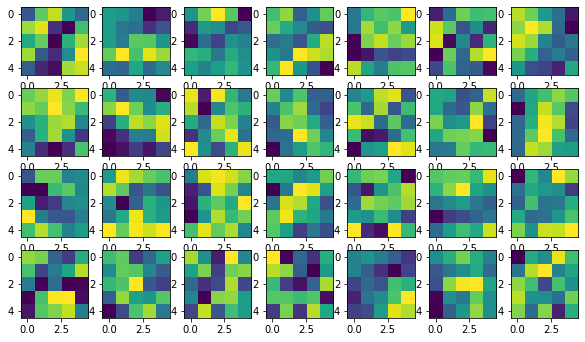

In [65]:
WIDTH = 10
rows, columns = pseudo_square_roots(NUM_FEATURES)
HEIGHT = rows / columns * 10
plt.figure(figsize=(WIDTH, HEIGHT))
for i in range(NUM_FEATURES):
    plt.subplot(rows, columns, i+1)
    feature = model.conv_pool[0].weight.cpu().detach()[i].numpy().reshape((5, 5))
    plt.imshow(feature)